# Text Classification with RoBERTa

The RoBERTa model was proposed in RoBERTa: A Robustly Optimized BERT Pretraining Approach by Yinhan Liu et al. It is based on Google’s BERT model released in 2018: it modifies key hyperparameters, removing the next-sentence pretraining objective and training with much larger mini-batches and learning rates.

This notebook is also available in Kaggle: https://www.kaggle.com/dimasmunoz/text-classification-with-roberta-and-tpus

See:
- RoBERTa's paper: https://arxiv.org/pdf/1907.11692.pdf
- BERT's paper: https://arxiv.org/pdf/1810.04805.pdf

In [1]:
import numpy as np
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
from transformers import RobertaTokenizer, TFRobertaModel

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [2]:
# Detect hardware, return appropriate distribution strategy (you can see that it is pretty easy to set up).
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set (always set in Kaggle)
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
Number of replicas: 8


In [3]:
MODEL_NAME = 'roberta-base'
MAX_LEN = 256
ARTIFACTS_PATH = '../artifacts/'

BATCH_SIZE = 8 * strategy.num_replicas_in_sync
EPOCHS = 3

if not os.path.exists(ARTIFACTS_PATH):
    os.makedirs(ARTIFACTS_PATH)

## Prepare dataset

Note that I have already cleaned the dataset, so the training should be better:
- Remove punctuation symbols and double white spaces.
- Lemmatization.
- Remove stop words (see `spacy.lang.en.stop_words.STOP_WORDS`).
- TD-IDF

The reason of this preprocess is that I have used this dataset with other models, such as LSTM. However, I believe (I didn't test it) that RoBERTa could deal with it.

In [4]:
df = pd.read_csv('/kaggle/input/bbc-articles-cleaned/tfidf_dataset.csv')
df.head()

,text,category
0,musicians tackle red tape musicians groups tac...,entertainment
1,u2 desire number u2 won prestigious grammy awa...,entertainment
2,rocker doherty stage fight rock singer pete do...,entertainment
3,snicket tops box office chart film adaptation ...,entertainment
4,ocean raids box office ocean crime caper seque...,entertainment


In [5]:
X_data = df[['text']].to_numpy().reshape(-1)
y_data = df[['category']].to_numpy().reshape(-1)

# Dataset analysis

As you can see in the following plot, the samples **are not balanced**. This could cause problems during the training but, since they are not highly unbalanced, I have left it as it is.

In other cases, such as fraud detecting where the positive classes are very few compared to the negative ones, we must apply techniques to balance it. For example, we could undersample the biggest category.

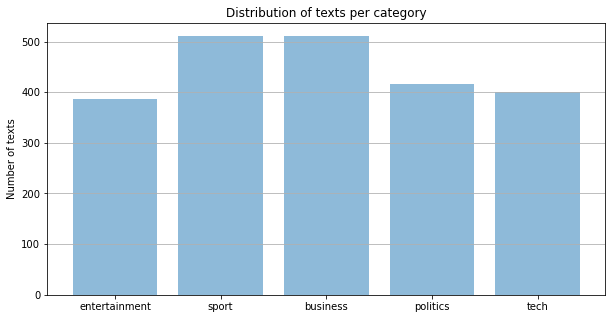

Counter({'sport': 511, 'business': 510, 'politics': 417, 'tech': 401, 'entertainment': 386})


In [6]:
categories = df[['category']].values.reshape(-1)

counter_categories = Counter(categories)
category_names = counter_categories.keys()
category_values = counter_categories.values()

y_pos = np.arange(len(category_names))

plt.figure(1, figsize=(10, 5))
plt.bar(y_pos, category_values, align='center', alpha=0.5)
plt.xticks(y_pos, category_names)
plt.ylabel('Number of texts')
plt.title('Distribution of texts per category')
plt.gca().yaxis.grid(True)
plt.show()

print(counter_categories)

In [7]:
def calculate_stats(df, split_char=' '):
    categories = df['category'].unique()
    
    all_lengths = []
    per_category = {
        'lengths': {c:[] for c in categories},
        'mean': {c:0 for c in categories},
        'stdev': {c:0 for c in categories}
    }

    for index, row in df.iterrows():
        text = row['text']
        text = re.sub(r"\s+", ' ', text) # Normalize
        text = text.split(split_char)
        l = len(text)
        
        category = row['category']
        
        all_lengths.append(l)
        per_category['lengths'][category].append(l)
    
    for c in categories:
        per_category['mean'][c] = statistics.mean(per_category['lengths'][c])
        per_category['stdev'][c] = statistics.stdev(per_category['lengths'][c])
    
    global_stats = {
        'mean': statistics.mean(all_lengths),
        'stdev': statistics.stdev(all_lengths),
        'lengths': all_lengths
    }
    
    return {
        'global': global_stats,
        'per_category': pd.DataFrame(per_category)
    }


def display_lengths_histograms(df_stats, n_cols=3):
    categories = df['category'].unique()
    n_rows = math.ceil(len(categories) / n_cols)
    
    plt.figure(figsize=(15, 8))
    plt.suptitle('Distribution of lengths')
    
    # Subplot of all lengths
    plt.subplot(n_rows, n_cols, 1)
    plt.title('All categories')
    lengths = df_stats['global']['lengths']
    plt.hist(lengths, color='r')

    # Subplot of each category
    index_subplot = 2
    for c in categories:
        plt.subplot(n_rows, n_cols, index_subplot)
        plt.title('Category: %s' % c)
        
        lengths = df_stats['per_category']['lengths'][c]
        plt.hist(lengths, color='b')

        index_subplot += 1

    plt.show()

In these histograms and stats, we can see that almost all texts contain $500$ or less words. Also, we can see that the average length is very different depending on the category.

Please, note that the tokenization process may split words into several parts, so lengths could increase (or decrease too). This is only an orientative result.

In [8]:
df_stats = calculate_stats(df)
df_stats['per_category']

,lengths,mean,stdev
entertainment,"[165, 375, 174, 108, 167, 189, 130, 230, 115, ...",168.585492,118.648402
sport,"[86, 86, 92, 72, 71, 68, 703, 257, 226, 71, 71...",159.681018,92.709783
business,"[90, 82, 105, 169, 229, 321, 100, 85, 82, 127,...",172.876471,65.119283
politics,"[115, 297, 289, 116, 208, 235, 231, 183, 113, ...",215.347722,128.812873
tech,"[194, 117, 274, 135, 223, 170, 222, 165, 168, ...",241.835411,103.570666


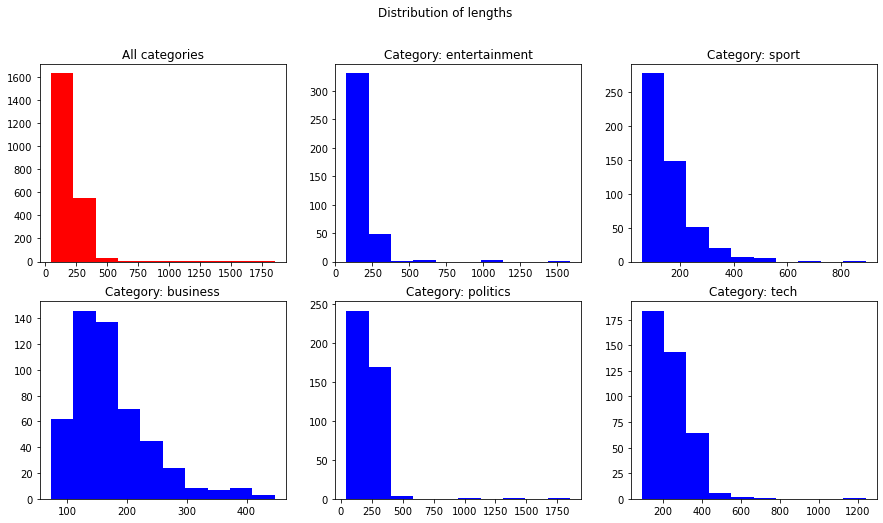

In [9]:
display_lengths_histograms(df_stats)

In [10]:
n_texts = len(X_data)
print('Texts in dataset: %d' % n_texts)

categories = df['category'].unique()
n_categories = len(categories)
print('Number of categories: %d' % n_categories)

print('Done!')

Texts in dataset: 2225
Number of categories: 5
Done!


# Tokenize & encode

I am going to import the RoBERTa model from HuggingFace. Note that I must import not only the model but also the tokenizer (since I must use the same vocabulary as the model was trained with).

We should take into account that RoBERTa's input accepts up-to 512 tokens, thus **we must truncate the tokenized texts**. In my case, I truncate to 256 tokens, but you can put a higher value in the variable `MAX_LEN`.

See https://huggingface.co/roberta-base

In [11]:
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)
        
        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])
        
        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN
        
        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
        
        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [12]:
# Transform categories into numbers
category_to_id = {}
category_to_name = {}

for index, c in enumerate(y_data):
    if c in category_to_id:
        category_id = category_to_id[c]
    else:
        category_id = len(category_to_id)
        category_to_id[c] = category_id
        category_to_name[category_id] = c
    
    y_data[index] = category_id

# Display dictionary
category_to_name

{0: 'entertainment', 1: 'sport', 2: 'business', 3: 'politics', 4: 'tech'}

In [13]:
# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=777) # random_state to reproduce results

In [14]:
# Import tokenizer from HuggingFace
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

In [15]:
X_train = roberta_encode(X_train, tokenizer)
X_test = roberta_encode(X_test, tokenizer)

y_train = np.asarray(y_train, dtype='int32')
y_test = np.asarray(y_test, dtype='int32')

## Create RoBERTa model

In [16]:
def build_model(n_categories):
    with strategy.scope():
        input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

        # Import RoBERTa model from HuggingFace
        roberta_model = TFRobertaModel.from_pretrained(MODEL_NAME)
        x = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

        # Huggingface transformers have multiple outputs, embeddings are the first one,
        # so let's slice out the first position
        x = x[0]

        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dense(n_categories, activation='softmax')(x)

        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(lr=1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

        return model

In [17]:
with strategy.scope():
    model = build_model(n_categories)
    model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode ((None, 256, 768), ( 124645632   input_word_ids[0][0]             
_____________________________________________________________________________________________

## Train model

This is basic training of RoBERTa but, if your dataset is larger, you may use K-Folds in this section. In this notebook, I use K-Folds (use it as inspiration): https://www.kaggle.com/dimasmunoz/clean-english-data-roberta ;)

In [18]:
with strategy.scope():
    print('Training...')
    history = model.fit(X_train,
                        y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        verbose=1,
                        validation_data=(X_test, y_test))

Training...
Epoch 1/3
25/25 [==============================] - 40s 2s/step - loss: 0.6481 - accuracy: 0.7720 - val_loss: 0.1106 - val_accuracy: 0.9671
Epoch 2/3
25/25 [==============================] - 4s 152ms/step - loss: 0.0792 - accuracy: 0.9743 - val_loss: 0.0749 - val_accuracy: 0.9716
Epoch 3/3
25/25 [==============================] - 4s 149ms/step - loss: 0.0267 - accuracy: 0.9917 - val_loss: 0.0586 - val_accuracy: 0.9775


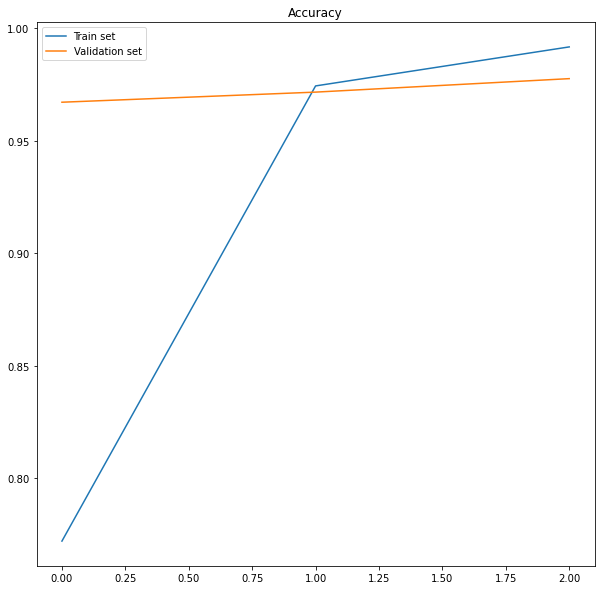

In [19]:
# This plot will look much better if we train models with more epochs, but anyway here is
plt.figure(figsize=(10, 10))
plt.title('Accuracy')

xaxis = np.arange(len(history.history['accuracy']))
plt.plot(xaxis, history.history['accuracy'], label='Train set')
plt.plot(xaxis, history.history['val_accuracy'], label='Validation set')
plt.legend()

## Evaluation

In a confusion matrix, we can see how many categories are classified c

In [20]:
def plot_confusion_matrix(X_test, y_test, model):
    y_pred = model.predict(X_test)
    y_pred = [np.argmax(i) for i in model.predict(X_test)]

    con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()

    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    label_names = list(range(len(con_mat_norm)))

    con_mat_df = pd.DataFrame(con_mat_norm,
                              index=label_names, 
                              columns=label_names)

    figure = plt.figure(figsize=(10, 10))
    sns.heatmap(con_mat_df, cmap=plt.cm.Blues, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [21]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

Accuracy: 97.75%


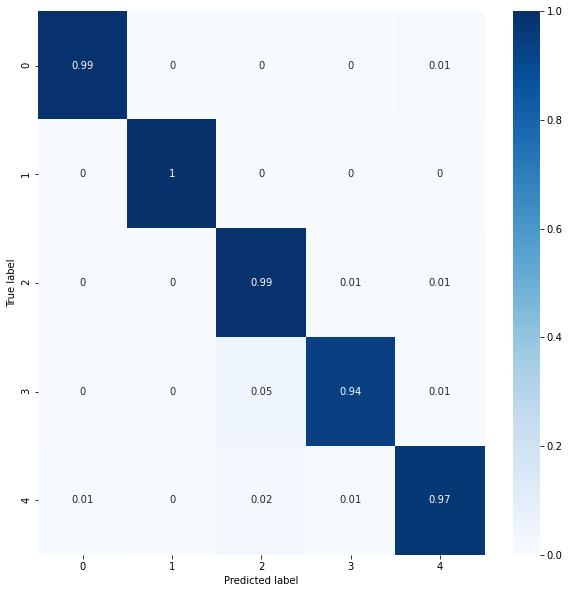

In [22]:
plot_confusion_matrix(X_test, y_test, model)